In [1]:
import pandas as pd
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

In [2]:
# ratings = pd.read_csv('../../data/lens_tmdb/ratings.csv')
ratings = pd.read_csv('../../data/lens_tmdb/ratings_small.csv')
info = pd.read_csv('../../data/lens_tmdb/cleaned/df_all.csv')

In [3]:
ratings.columns

Index(['userId', 'movieId', 'rating', 'timestamp'], dtype='object')

In [4]:
# Encode users and movies as integer indices
user_enc = LabelEncoder()
ratings['userId'] = user_enc.fit_transform(ratings['userId'].values)
n_users = ratings['userId'].nunique()

movie_enc = LabelEncoder()
ratings['movieId'] = movie_enc.fit_transform(ratings['movieId'].values)
n_movies = ratings['movieId'].nunique()

# Split data into train and test sets
train, test = train_test_split(ratings, test_size=0.2, random_state=42)


In [5]:
class MovieLensDataset(Dataset):
    def __init__(self, ratings):
        self.users = ratings['userId'].values
        self.movies = ratings['movieId'].values
        self.ratings = ratings['rating'].values

    def __len__(self):
        return len(self.ratings)

    def __getitem__(self, idx):
        return self.users[idx], self.movies[idx], self.ratings[idx]


In [6]:
class WideAndDeepModel(nn.Module):
    def __init__(self, n_users, n_movies, n_factors, embedding_dropout, hidden_layers, dropouts):
        super().__init__()

        # Embeddings
        self.user_embedding = nn.Embedding(n_users, n_factors)
        self.movie_embedding = nn.Embedding(n_movies, n_factors)
        self.embedding_dropout = nn.Dropout(embedding_dropout)

        # Linear Layers
        self.hidden_layers = nn.ModuleList([nn.Linear(n_factors*2, hidden_layers[0])])
        for i in range(1, len(hidden_layers)):
            self.hidden_layers.append(nn.Linear(hidden_layers[i-1], hidden_layers[i]))
        self.output_layer = nn.Linear(hidden_layers[-1], 1)

        # Dropout Layers
        self.dropout_layers = nn.ModuleList([nn.Dropout(dropout) for dropout in dropouts])

    def forward(self, users, movies):
        user_embeds = self.user_embedding(users)
        movie_embeds = self.movie_embedding(movies)

        # Combine the embeddings (concatenate)
        x = torch.cat([user_embeds, movie_embeds], dim=1)
        x = self.embedding_dropout(x)

        # Pass through the hidden layers
        for hidden_layer, dropout_layer in zip(self.hidden_layers, self.dropout_layers):
            x = hidden_layer(x)
            x = nn.ReLU()(x)
            x = dropout_layer(x)

        # Output layer
        out = self.output_layer(x)

        return out


In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
train_loader = DataLoader(MovieLensDataset(train), batch_size=1024, shuffle=True)
test_loader = DataLoader(MovieLensDataset(test), batch_size=1024)

# Create model
model = WideAndDeepModel(n_users, n_movies, n_factors=50, embedding_dropout=0.05, hidden_layers=[128, 64], dropouts=[0.5, 0.5])
model.to(device)

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
for epoch in range(100):  # 10 epochs
    model.train()
    for users, movies, ratings in train_loader:
        users = users.to(device)
        movies = movies.to(device)
        ratings = ratings.float().to(device)

        optimizer.zero_grad()
        preds = model(users, movies).squeeze()
        loss = loss_func(preds, ratings)
        loss.backward()
        optimizer.step()

    print(f"Epoch {epoch+1}, Loss: {loss.item()}")


Epoch 1, Loss: 1.7689365148544312
Epoch 2, Loss: 1.6901477575302124
Epoch 3, Loss: 1.6938292980194092
Epoch 4, Loss: 1.3302524089813232
Epoch 5, Loss: 1.5551340579986572
Epoch 6, Loss: 1.098506212234497
Epoch 7, Loss: 1.463148832321167
Epoch 8, Loss: 1.4096421003341675
Epoch 9, Loss: 1.0712894201278687
Epoch 10, Loss: 1.361520767211914
Epoch 11, Loss: 1.1772788763046265
Epoch 12, Loss: 1.1101528406143188
Epoch 13, Loss: 1.186075210571289
Epoch 14, Loss: 0.9552815556526184
Epoch 15, Loss: 1.363431453704834
Epoch 16, Loss: 1.0876288414001465
Epoch 17, Loss: 1.0177388191223145
Epoch 18, Loss: 1.1412376165390015
Epoch 19, Loss: 1.1930053234100342
Epoch 20, Loss: 1.1718292236328125
Epoch 21, Loss: 0.9862584471702576
Epoch 22, Loss: 0.9349762201309204
Epoch 23, Loss: 0.9419924020767212
Epoch 24, Loss: 0.7715575695037842
Epoch 25, Loss: 0.940818727016449
Epoch 26, Loss: 0.9099485874176025
Epoch 27, Loss: 1.1632298231124878
Epoch 28, Loss: 1.0830600261688232
Epoch 29, Loss: 1.1690621376037598


In [37]:
# Ensure your model is in eval mode
model.eval()

# Get the device where your model is
device = next(model.parameters()).device

# User and Movie tensors
user_tensor = torch.tensor([50]).to(device)
movie_tensor = torch.tensor([100]).to(device)

# Make the prediction
with torch.no_grad():
    prediction = model(user_tensor, movie_tensor)

print(f"Predicted rating: {prediction.item()}")


Predicted rating: 4.4666829109191895


In [38]:
model.eval()
test_preds = torch.tensor([]).to(device)
test_targets = torch.tensor([]).to(device)

with torch.no_grad():
    for users, movies, ratings in test_loader:
        users = users.to(device)
        movies = movies.to(device)
        ratings = ratings.float().to(device)

        preds = model(users, movies).squeeze()

        test_preds = torch.cat((test_preds, preds), dim=0)
        test_targets = torch.cat((test_targets, ratings), dim=0)

test_preds = test_preds.cpu().numpy()
test_targets = test_targets.cpu().numpy()

mse = ((test_preds - test_targets) ** 2).mean()
rmse = np.sqrt(mse)
mae = np.abs(test_preds - test_targets).mean()

print(f"RMSE: {rmse}")
print(f"MAE: {mae}")


RMSE: 0.9105514287948608
MAE: 0.6973023414611816


Epoch 1, Train Loss: 3.699833172786085
Epoch 1, Test Loss: 1.1453373372554778
Epoch 2, Train Loss: 1.784793530838399
Epoch 2, Test Loss: 1.0768674254417419
Epoch 3, Train Loss: 1.6716079757183413
Epoch 3, Test Loss: 1.0555724442005157
Epoch 4, Train Loss: 1.610397015945821
Epoch 4, Test Loss: 1.0264669120311738
Epoch 5, Train Loss: 1.5417902952508082
Epoch 5, Test Loss: 0.9878491461277008
Epoch 6, Train Loss: 1.4994324189198167
Epoch 6, Test Loss: 0.9743865668773651
Epoch 7, Train Loss: 1.4524176995965499
Epoch 7, Test Loss: 0.9768099218606949
Epoch 8, Train Loss: 1.4184581629837616
Epoch 8, Test Loss: 0.9443901956081391
Epoch 9, Train Loss: 1.3811106168771092
Epoch 9, Test Loss: 0.9728140294551849
Epoch 10, Train Loss: 1.3467259920096095
Epoch 10, Test Loss: 0.9261653989553451


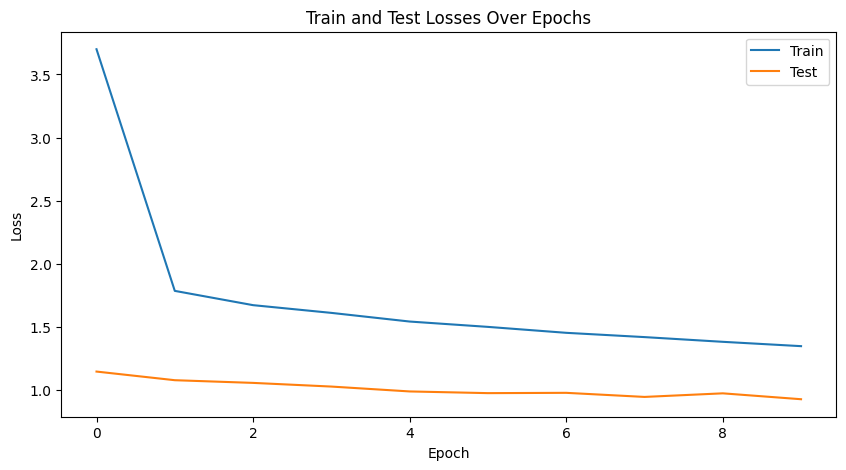

Predicted rating: 3.651121139526367


In [7]:
import matplotlib.pyplot as plt
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create data loaders
train_loader = DataLoader(MovieLensDataset(train), batch_size=1024, shuffle=True)
test_loader = DataLoader(MovieLensDataset(test), batch_size=1024)

# Create model
model = WideAndDeepModel(n_users, n_movies, n_factors=50, embedding_dropout=0.05, hidden_layers=[128, 64], dropouts=[0.5, 0.5])
model.to(device)

# Define loss function and optimizer
loss_func = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_losses = []
test_losses = []
# Training loop
for epoch in range(10):  # 10 epochs
    model.train()
    total_loss = 0.0
    for users, movies, ratings in train_loader:
        users = users.to(device)
        movies = movies.to(device)
        ratings = ratings.float().to(device)

        optimizer.zero_grad()
        preds = model(users, movies).squeeze()
        loss = loss_func(preds, ratings)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)
    train_losses.append(avg_train_loss)
    print(f"Epoch {epoch+1}, Train Loss: {avg_train_loss}")

    model.eval()
    total_test_loss = 0.0
    with torch.no_grad():
        for users, movies, ratings in test_loader:
            users = users.to(device)
            movies = movies.to(device)
            ratings = ratings.float().to(device)

            preds = model(users, movies).squeeze()
            loss = loss_func(preds, ratings)
            total_test_loss += loss.item()

    avg_test_loss = total_test_loss / len(test_loader)
    test_losses.append(avg_test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {avg_test_loss}")

# Plotting the training and testing losses
plt.figure(figsize=(10,5))
plt.plot(np.arange(len(train_losses)), train_losses, label='Train')
plt.plot(np.arange(len(test_losses)), test_losses, label='Test')
plt.legend(loc='upper right')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train and Test Losses Over Epochs')
plt.show()

# Ensure your model is in eval mode
model.eval()

# Get the device where your model is
device = next(model.parameters()).device

# User and Movie tensors
user_tensor = torch.tensor([50]).to(device)
movie_tensor = torch.tensor([100]).to(device)

# Make the prediction
with torch.no_grad():
    prediction = model(user_tensor, movie_tensor)

print(f"Predicted rating: {prediction.item()}")
